In [1]:
import os
import numpy as np
import xarray as xr
from som import SOM, GeoSOM, SSIM
import pandas as pd
from datetime import datetime
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from gesospatialmutils import subseason, anomaly, akplots

In [2]:
def geopotential_to_z(x):
    return np.divide(x, 9.81)

def Pa_to_hPa(x):
    return np.divide(x, 100.0)

levels_dict = {'temperature': ['850', '500'],
               'geopotential': ['500'],
               'mean_sea_level_pressure': [None],
               '2m_temperature': [None],
               'convective_precipitation': [None],
               'total_column_cloud_ice_water': [None],
               'total_column_cloud_liquid_water': [None],
               'convective_available_potential_energy': [None],
               'total_column_water_vapour': [None]}

products_vars = {'reanalysis-era5-single-levels': ['mean_sea_level_pressure',],
                 'reanalysis-era5-pressure-levels': ['geopotential',]}

idx_dict = {r'2m_temperature': 't2m',
            r'geopotential': 'z',
            r'temperature': 't',
            r'convective_available_potential_energy': 'cape',
            r'mean_sea_level_pressure': 'msl',
            r'total_column_cloud_ice_water': 'tciw',
            r'total_column_cloud_liquid_water': 'tclw',
            r'total_column_water_vapour': 'tcwv',
            'convective_precipitation': 'cp'}

func_dict = {'geopotential': geopotential_to_z,
             'mean_sea_level_pressure': Pa_to_hPa,
             '2m_temperature': None,
             'convective_precipitation': None,
             'total_column_cloud_ice_water': None,
             'total_column_cloud_liquid_water': None,
             'convective_available_potential_energy': None,
             'total_column_water_vapour': None,
             'temperature': None}

clevs_dict = {'geopotential': np.asarray([-198, -162, -126, -90, -54, -18, 18, 54, 90, 126, 162, 198]),
             'mean_sea_level_pressure': np.asarray([-11, -9, -7, -5, -3, -1, 1, 3, 5, 7, 9, 11]),
             '2m_temperature': None,
             'convective_precipitation': None,
             'total_column_cloud_ice_water': None,
             'total_column_cloud_liquid_water': None,
             'convective_available_potential_energy': None,
             'total_column_water_vapour': None,
             'temperature': None}




duff = subseason(datetime(1986, 6, 11),
                 datetime(2022, 7, 9))

june = subseason(datetime(1986, 6, 1),
                 datetime(2022, 6, 30))

july = subseason(datetime(1986, 7, 1),
                 datetime(2022, 7, 31))

jj = subseason(datetime(1959, 6, 1),
                 datetime(2022, 7, 31))

jj2004 = subseason(datetime(2004, 6, 1),
                 datetime(2022, 7, 31))

fseason = subseason(datetime(1959, 4, 1),
                    datetime(2022, 9, 30))

label_df = pd.DataFrame()

1013.7171


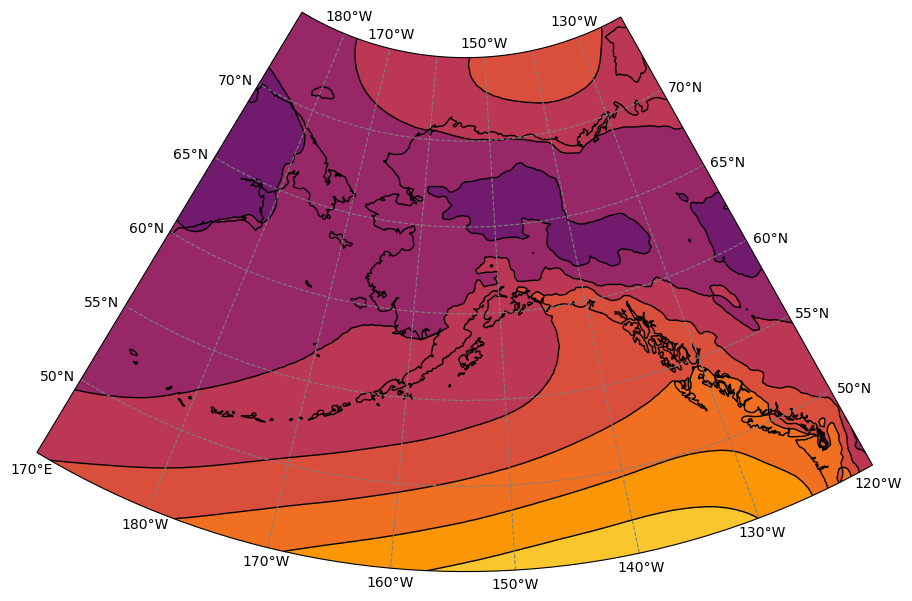

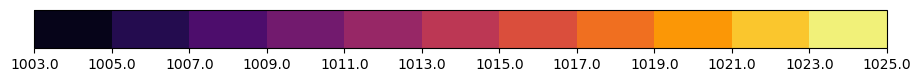

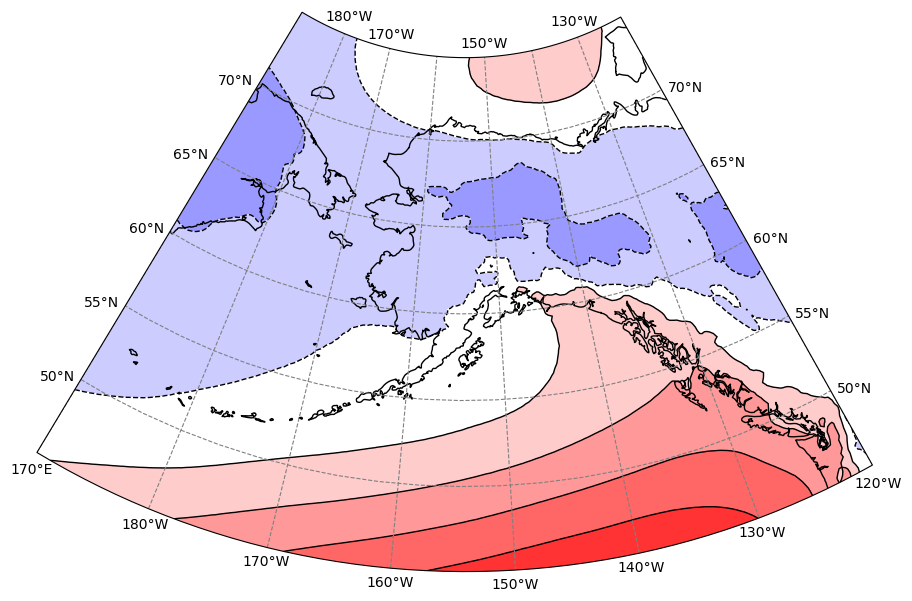

0.0


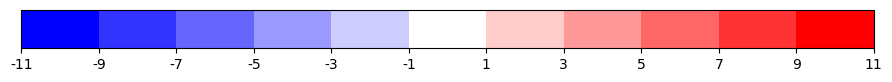

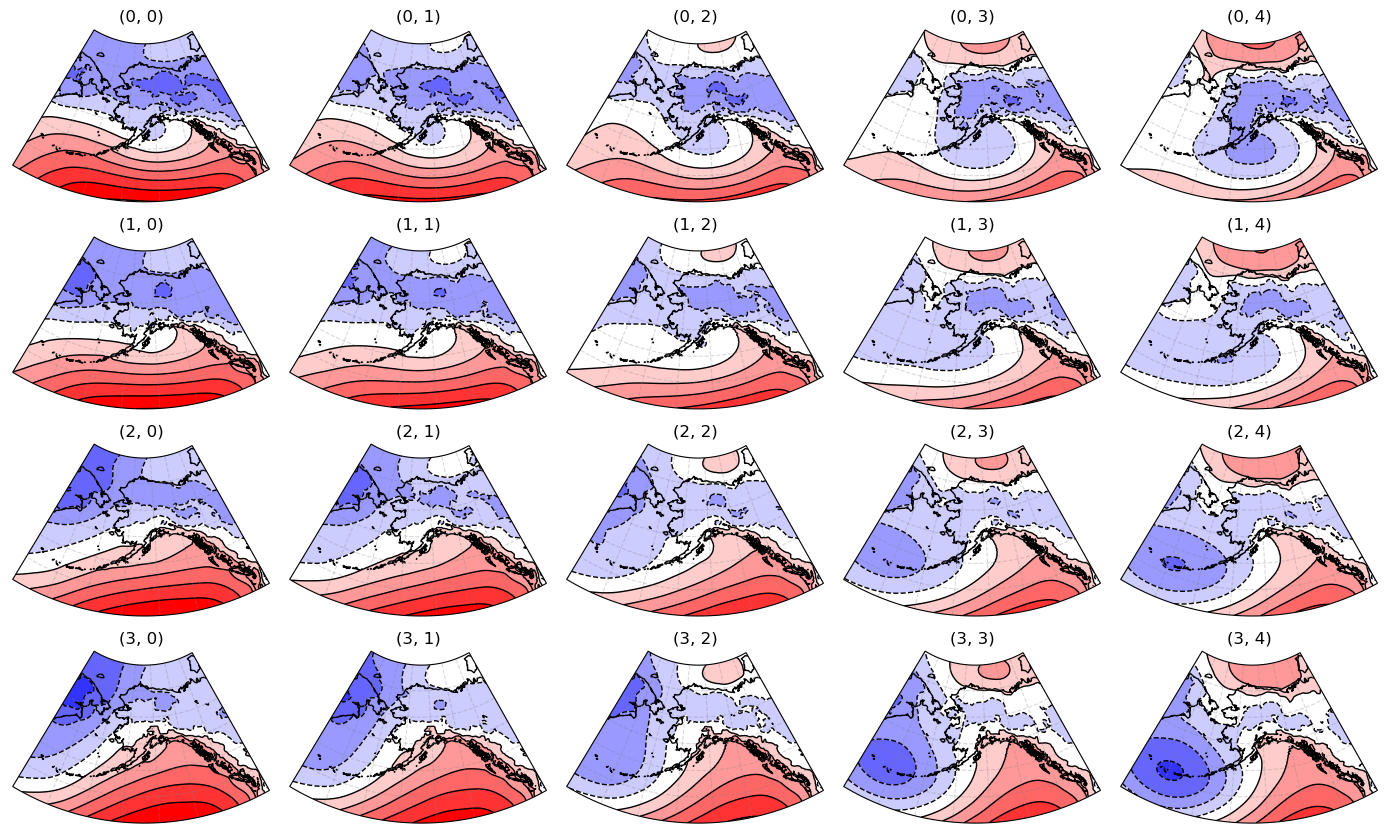

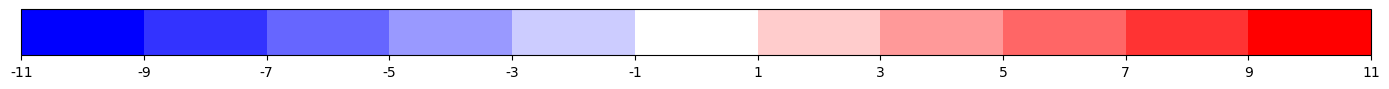

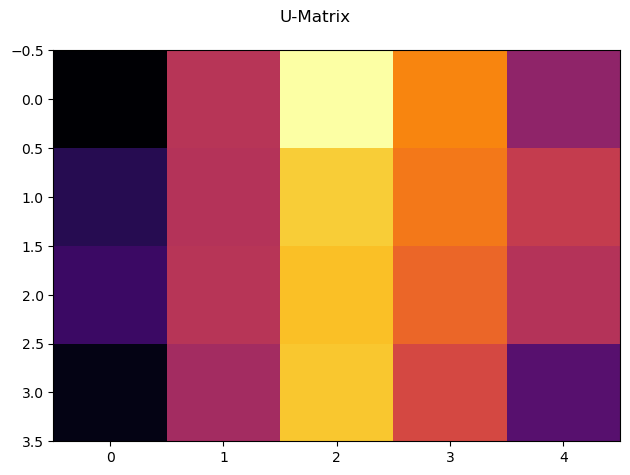

5604.103


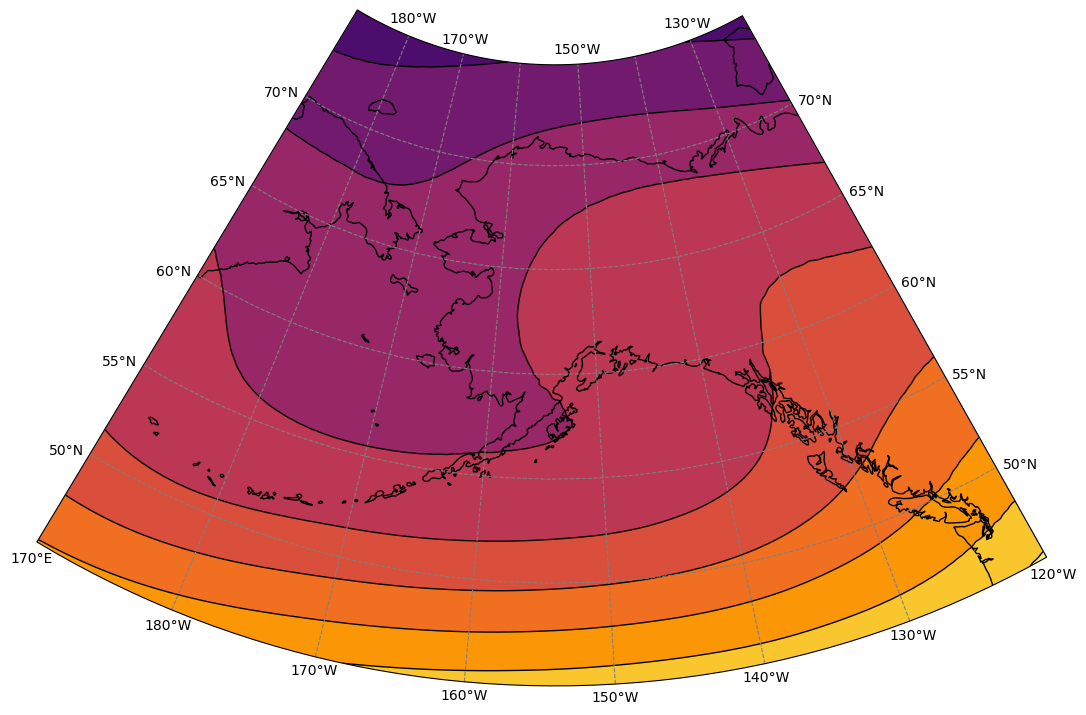

C:\Users\harpe\anaconda3\envs\SOM311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


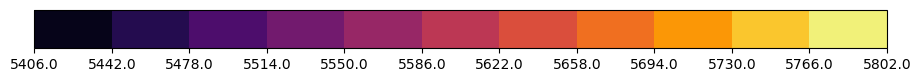

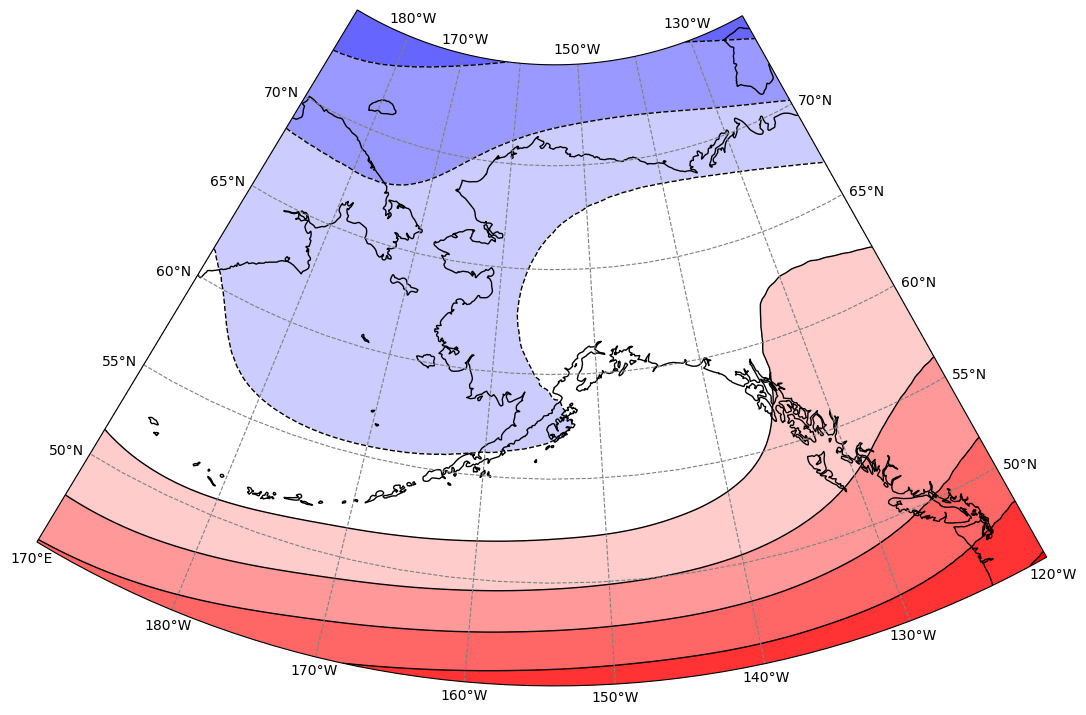

0.0


C:\Users\harpe\anaconda3\envs\SOM311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


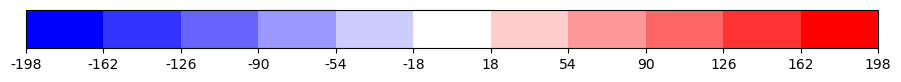

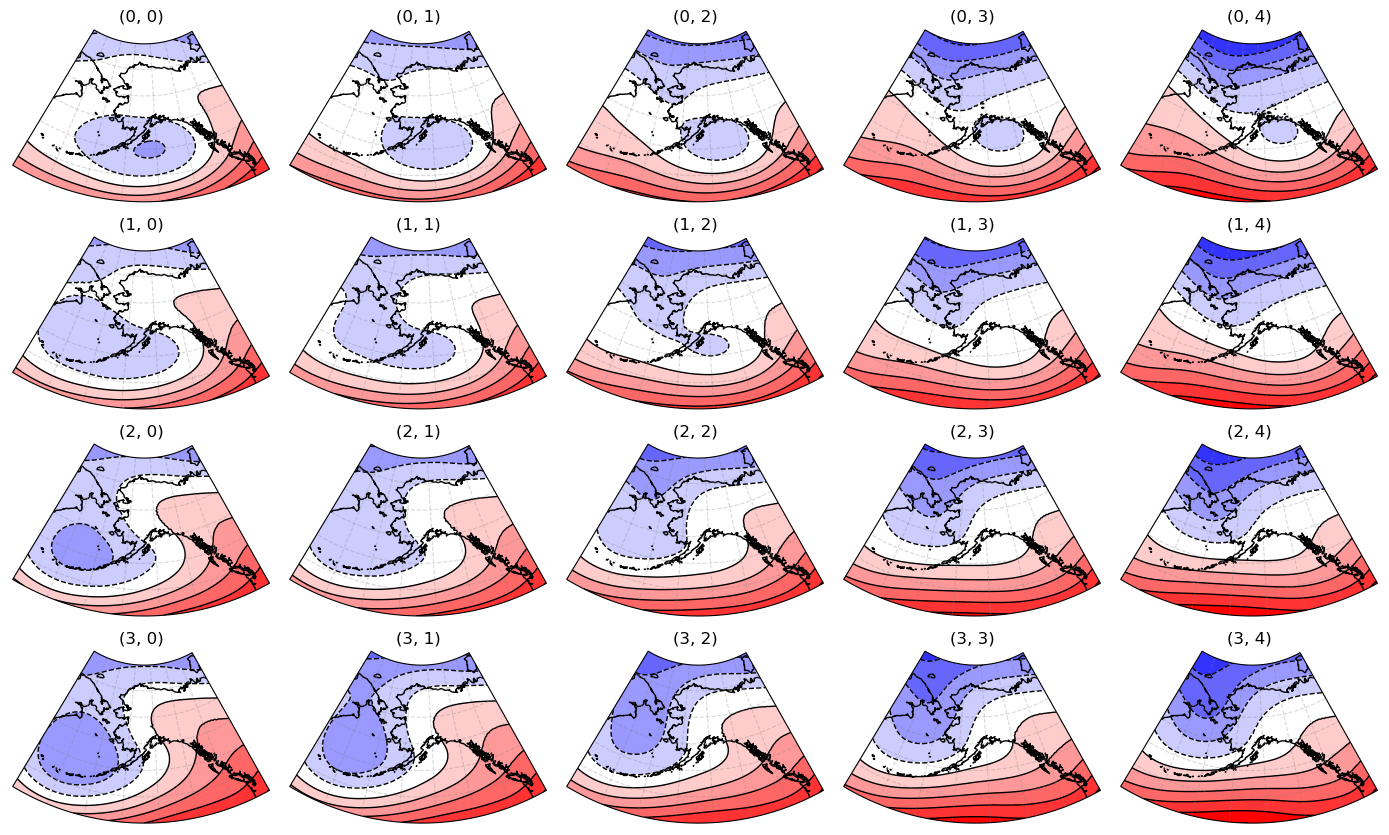

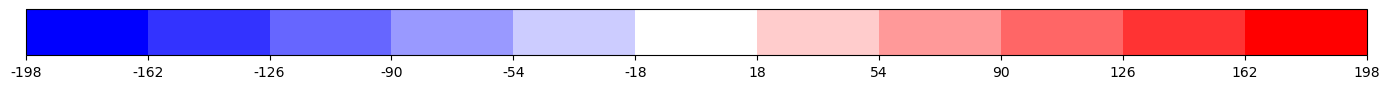

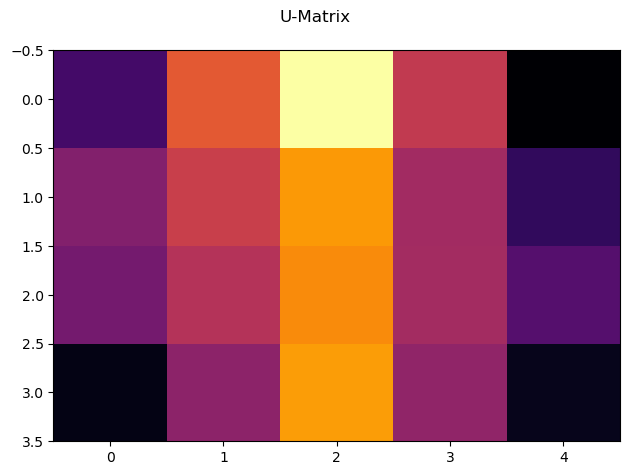

In [3]:
nrows = 4
ncols = 5
iters = 2000
ROOT_PATH = rf'C:\Users\harpe\PycharmProjects\synoptic-SOM\results\localtime\jj_spatial_anom\{nrows}{ncols}\{iters}\\'

for product, var_list in products_vars.items():
    for var in var_list:
        f = idx_dict[var]
        for level in levels_dict[var]:
            if level:
                mu_dir = os.path.join(r'Z:\fiboreal\jphostler\data\daily_mean_localtime', product, level, f, "")
                fn_out = ROOT_PATH + r'models\\' + level + f + f'_c.som'
                init_fn = ROOT_PATH + r'models\\' + level + f + f'_c.som'
            else:
                mu_dir = os.path.join(r'Z:\fiboreal\jphostler\data\daily_mean_localtime', product, f, "")
                fn_out = ROOT_PATH + r'models\\' + f + r'_c.som'
                init_fn = ROOT_PATH + r'models\\' + f + r'_c.som'
            ds = xr.open_mfdataset(os.path.join(mu_dir, var + '*.nc'))
            ds.load()
            if func_dict[var]:
                ds = ds.map(func_dict[var])

            weights = np.cos(np.deg2rad(ds.latitude))
            print(ds[f].sel(time=jj2004).mean().values)
            akplots(ds.sel(time=jj2004).mean(dim='time'),
                    f, cmap='inferno',
                    clevs=clevs_dict[var] + ds[f].sel(time=jj2004).mean().values)
            akplots(ds.sel(time=jj2004).mean(dim='time') - ds.sel(time=jj2004).mean(),
                    f, clevs=clevs_dict[var])

            #select subseason of interest
            ds = ds.sel(time=jj2004)

            #spatial anomaly with area weighting
            #ds = ds - ds.weighted(weights).mean(dim=['latitude', 'longitude'])
            #spatial anomaly without area weighting
            ds = anomaly(ds, kind='spatial')

            dim = ds[f].values.shape[1]*ds[f].values.shape[2]
            count = ds[f].values.shape[0]
            vals = ds[f].values.reshape(count, dim)
            if not os.path.exists(fn_out):
                dim = ds[f].values.shape[1]*ds[f].values.shape[2]
                count = ds[f].values.shape[0]
                vals = ds[f].values.reshape(count, dim)

                print(f'Training {var}')
                gs_v = GeoSOM(rows=nrows, cols=ncols, dim=dim,
                              lons=ds['longitude'], lats=ds['latitude'])
                gs_v.fit(obs_cpu=vals, lr=0.85, epoch=iters, k=0.90, init_fn=None)
                gs_v.to_csv(fn_out)

                labels = gs_v.mk_labels(vals)
                df = pd.DataFrame(data=labels, index=ds.time.values,
                                  columns=[f+'_row', f+'_column'])
                label_df = pd.concat([label_df, df], axis=1)
            else:
                s = SOM.from_csv(fn_out)

                gs_v = GeoSOM(s.rows, s.cols, s.dim, lons=ds['longitude'], lats=ds['latitude'])
                gs_v.nodes = s.nodes.copy()

                labels = gs_v.mk_labels(vals)
                df = pd.DataFrame(data=labels, index=ds.time.values,
                                  columns=[f+'_row', f+'_column'])
                label_df = pd.concat([label_df, df], axis=1)

            print(gs_v.TE(vals))
            if level:
                gs_v.plot_nodes(path_out=ROOT_PATH + level + f + r'_c.png',
                                colormap='coolwarm', nclevs=12, clevs=clevs_dict[var])
            else:
                gs_v.plot_nodes(path_out=ROOT_PATH + f + r'_c.png',
                                colormap='coolwarm', nclevs=12, clevs=clevs_dict[var])

            gs_v.u_matrix()


label_df.to_csv(ROOT_PATH + 'labels' + r'_c.csv')


In [4]:
label_df

,msl_row,msl_column,z_row,z_column
2004-06-01,1,4,0,0
2004-06-02,0,4,0,0
2004-06-03,0,4,1,0
2004-06-04,0,4,1,0
2004-06-05,0,4,0,0
...,...,...,...,...
2022-07-27,3,2,3,4
2022-07-28,2,4,3,2
2022-07-29,1,4,3,2
2022-07-30,1,4,3,3
